In [2]:
import os
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.conn.conn_spec import conn_spec
from tqdm import tqdm

import GDa.graphics.plot as plot
from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates

In [3]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

### Defining Morlet parameters

In [4]:
from mne.time_frequency import morlet

In [9]:
bands = np.array([[0, 3], [6, 14], [14, 26], [26, 42], [42, 80]])

f_c = np.array([3, 10, 20, 34, 61])
n_cycles = (f_c / (np.diff(bands, axis=-1).T * 0.5)).squeeze()

f_c      = np.linspace(3, 75, 10)
n_cycles = f_c/4.0
sfreq = 1000.0

In [10]:
W = morlet(sfreq, f_c, n_cycles)

In [11]:
P = []
for i in range(len(W)):
    Wfft = np.fft.fft(W[i], n=5000)
    P += [(Wfft * np.conj(Wfft)).real]
    P[i] = P[i] / np.max(P[i])
f_ax = np.linspace(0, sfreq, len(Wfft))

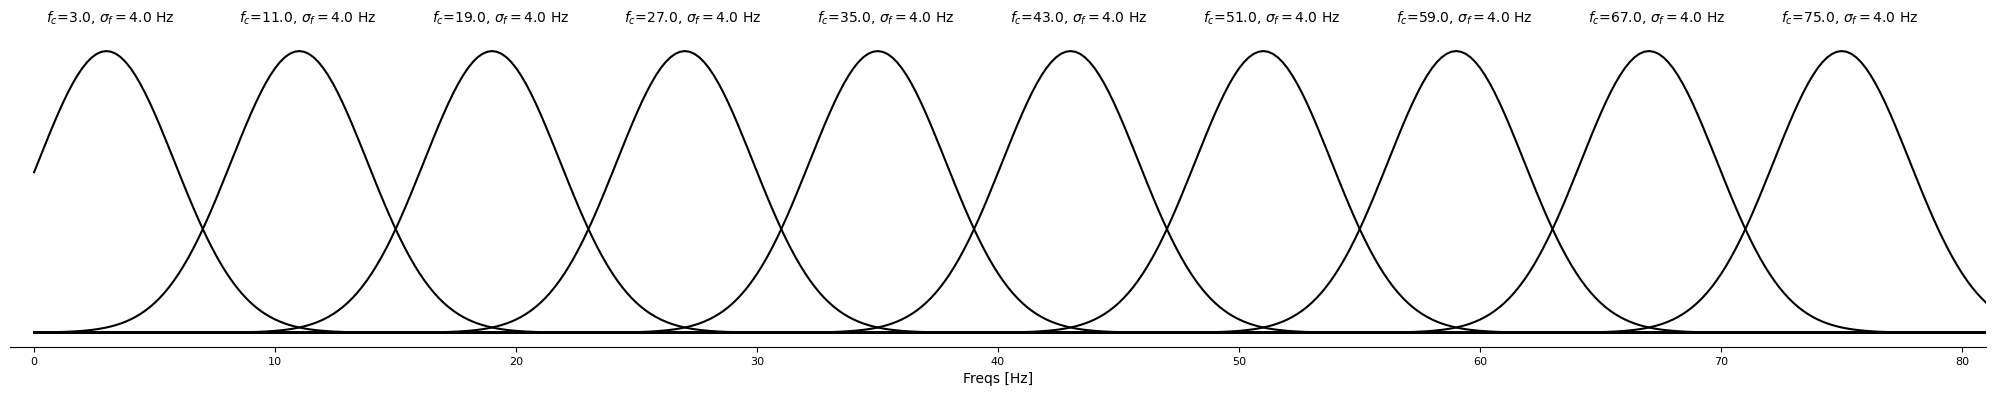

In [12]:
fig = plt.figure(figsize=(20, 4))
ax = plt.subplot(111)
for i in range(len(f_c)):
    plt.plot(f_ax, P[i], color="k")
    plt.xlim(-1, 81)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.yticks([])
    plt.text(
        f_c[i] - 2.5,
        1.1,
        r"$f_{c}$="
        + str(f_c[i])
        + r", $\sigma_f=$"
        + str(f_c[i] / n_cycles[i])
        + " Hz",
        fontsize=MEDIUM_SIZE,
    )
    plt.xlabel("Freqs [Hz]")
plt.tight_layout()

#### Loading data

In [8]:
# Instantiate class
ses = session(
    raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
    monkey="lucy",
    date="141017",
    session=1,
    slvr_msmod=False,
    align_to="cue",
    evt_dt=[-0.65, 3.00],
)

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1], behavioral_response=[1])

In [9]:
#### Surrogate data
n_surr = 1
data_surr = []
for i in range(n_surr):
    data_surr += [trial_swap_surrogates(data, seed=i + 500, verbose=False)]

#### Choosing pair of regions

These channel pairs display spectral peaks and strong coherence in Band 2. There are 2 short distance pairs (12-17, 17-18) and 1 long distance pair (17-181).

- 12 vs 17
- 17 vs 18
- 17 vs 181

These channel pairs display spectral peaks and strong coherence in Band 4. Both pairs are median distance examples.

- 69 vs 104
- 96 vs 106

In [18]:
channel_labels = np.array([12, 17, 18, 181, 69, 104, 95, 106])

In [19]:
channel_indexes = []
for c in channel_labels:
    channel_indexes += [np.where(data.attrs["channels_labels"] == c)[0][0]]

In [20]:
print(f"{channel_indexes=}")

channel_indexes=[6, 11, 12, 65, 30, 39, 36, 41]


In [21]:
pairs = np.array([[6, 11], [11, 12], [11, 65], [30, 39], [36, 41]])

### Spectral analysis

#### Static Fourier analysis

Here we plot the power-spectra and coherence of the channels of interested based of conventional Fourier analysis averaged over trials.

In [14]:
######################################################################################
######################################################################################
# Define function to plot power spectra
######################################################################################
######################################################################################
def plot_power_spectra(f, px, py, pxy, title=None):
    """
    f: Frequency axis
    px: Power spectra of signal X (n_trials, n_freqs)
    py: Power spectra of signal Y (n_trials, n_freqs)
    pxy: Cross-spectra between X and Y (n_trials, n_freqs)
    title: Title to insert in the plot
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    fig = plt.figure(figsize=(7.0, 3.8), dpi=150)

    gs1 = fig.add_gridspec(
        nrows=1, ncols=1, left=0.1, right=0.95, bottom=0.55, top=0.92
    )
    gs2 = fig.add_gridspec(
        nrows=1, ncols=1, left=0.1, right=0.95, bottom=0.13, top=0.50
    )

    ######################################################################################
    ######################################################################################
    # Power spectra
    ######################################################################################
    ######################################################################################
    ax1 = plt.subplot(gs1[0])

    plt.sca(ax1)
    plt.plot(f, px.mean(axis=0).real)
    plt.plot(f, py.mean(axis=0).real)
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 1e-4))
    plt.ylabel("Power")
    plt.xticks([])
    plt.xlim(0, 80)
    plt.title(title)
    axins = inset_axes(
        ax1,
        width="100%",
        height="100%",
        loc="upper left",
        bbox_to_anchor=(0.67, 0.3, 0.25, 0.6),
        bbox_transform=ax1.transAxes,
    )
    plt.plot(f, px.mean(axis=0).real)
    plt.plot(f, py.mean(axis=0).real)
    plt.xlim(50, 75)
    plt.yticks([])
    plt.ylim(0, 0.00005)

    # Panel B
    ax2 = plt.subplot(gs2[0])

    plt.sca(ax2)
    # Compute coherence
    C = np.abs(pxy.mean(0)) ** 2 / (px.mean(0) * py.mean(0))
    plt.plot(f, C.real)
    plt.xlim(0, 80)
    plt.ylabel("Coherence")
    plt.xlabel("Frequency [Hz]")

    bg = plot.Background(visible=False)

    plot.add_panel_letters(
        fig, axes=[ax1, ax2], fontsize=12, xpos=[-0.1, -0.1], ypos=[1, 1]
    )

##### a8B-a8M

In [15]:
# Fourier transform
xfft = np.fft.fft(ses.data.isel(roi=6), n=50000, axis=-1)
yfft = np.fft.fft(ses.data.isel(roi=11), n=50000, axis=-1)
# Compute spectra and frequency axis
px = xfft * np.conj(xfft)
py = yfft * np.conj(yfft)
pxy = xfft * np.conj(yfft)
f = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

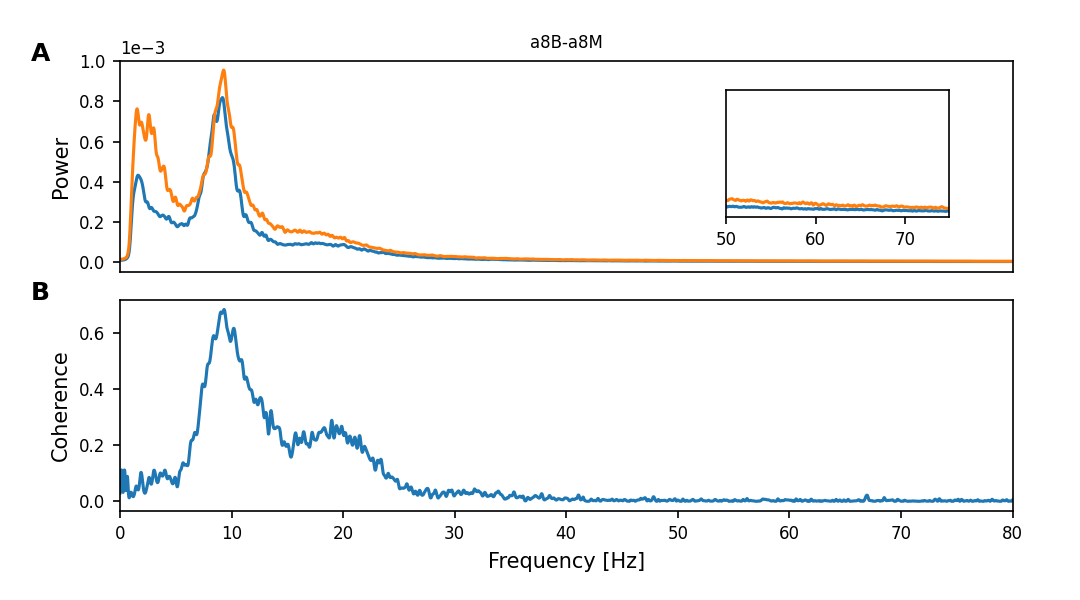

In [16]:
plot_power_spectra(f, px, py, pxy, title="a8B-a8M")

##### a8B-a8M

In [17]:
# Fourier transform
xfft = np.fft.fft(ses.data.isel(roi=11), n=50000, axis=-1)
yfft = np.fft.fft(ses.data.isel(roi=12), n=50000, axis=-1)
# Compute spectra and frequency axis
px = xfft * np.conj(xfft)
py = yfft * np.conj(yfft)
pxy = xfft * np.conj(yfft)
f = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

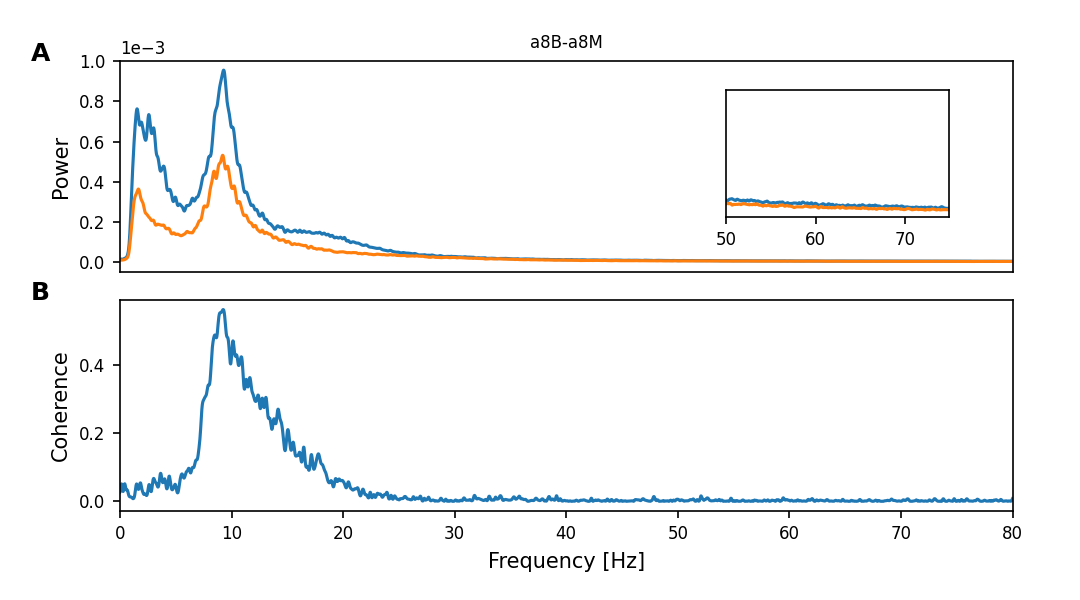

In [18]:
plot_power_spectra(f, px, py, pxy, title="a8B-a8M")

##### a7A-a8M

In [19]:
# Fourier transform
xfft = np.fft.fft(ses.data.isel(roi=11), n=50000, axis=-1)
yfft = np.fft.fft(ses.data.isel(roi=65), n=50000, axis=-1)
# Compute spectra and frequency axis
px = xfft * np.conj(xfft)
py = yfft * np.conj(yfft)
pxy = xfft * np.conj(yfft)
f = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

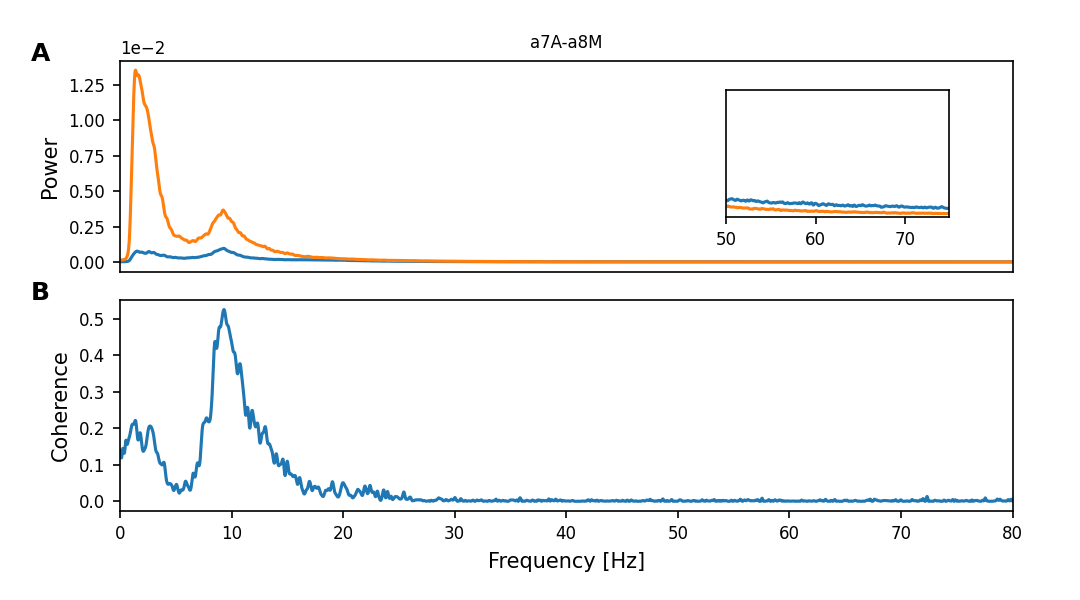

In [20]:
plot_power_spectra(f, px, py, pxy, title="a7A-a8M")

##### F1-F1

In [21]:
# Fourier transform
xfft = np.fft.fft(ses.data.isel(roi=30), n=50000, axis=-1)
yfft = np.fft.fft(ses.data.isel(roi=39), n=50000, axis=-1)
# Compute spectra and frequency axis
px = xfft * np.conj(xfft)
py = yfft * np.conj(yfft)
pxy = xfft * np.conj(yfft)
f = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

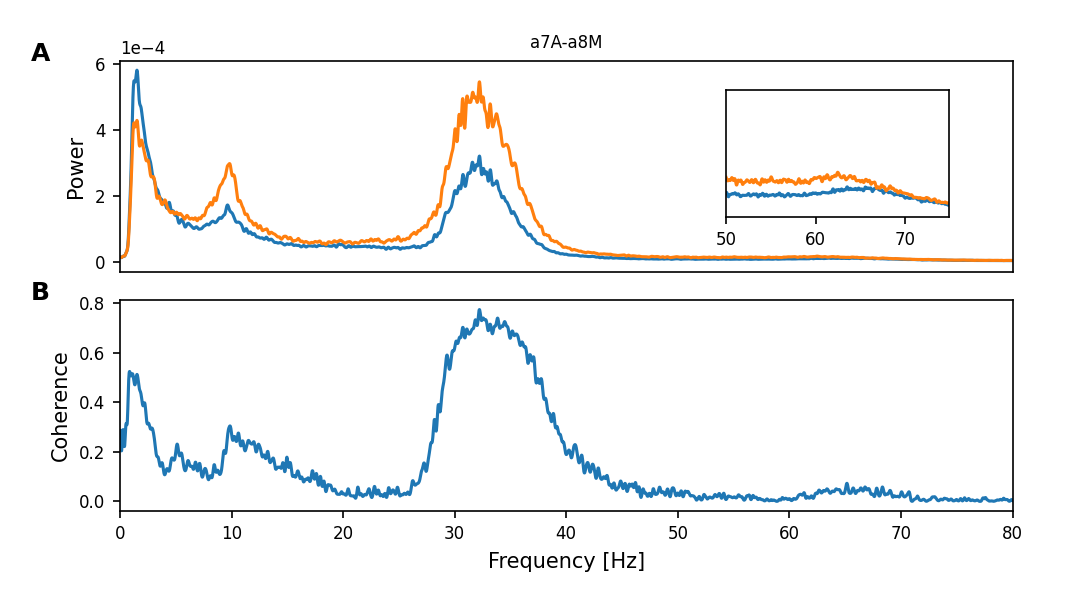

In [22]:
plot_power_spectra(f, px, py, pxy, title="a7A-a8M")

##### a3-F1

In [23]:
# Fourier transform
xfft = np.fft.fft(ses.data.isel(roi=36), n=50000, axis=-1)
yfft = np.fft.fft(ses.data.isel(roi=41), n=50000, axis=-1)
# Compute spectra and frequency axis
px = xfft * np.conj(xfft)
py = yfft * np.conj(yfft)
pxy = xfft * np.conj(yfft)
f = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

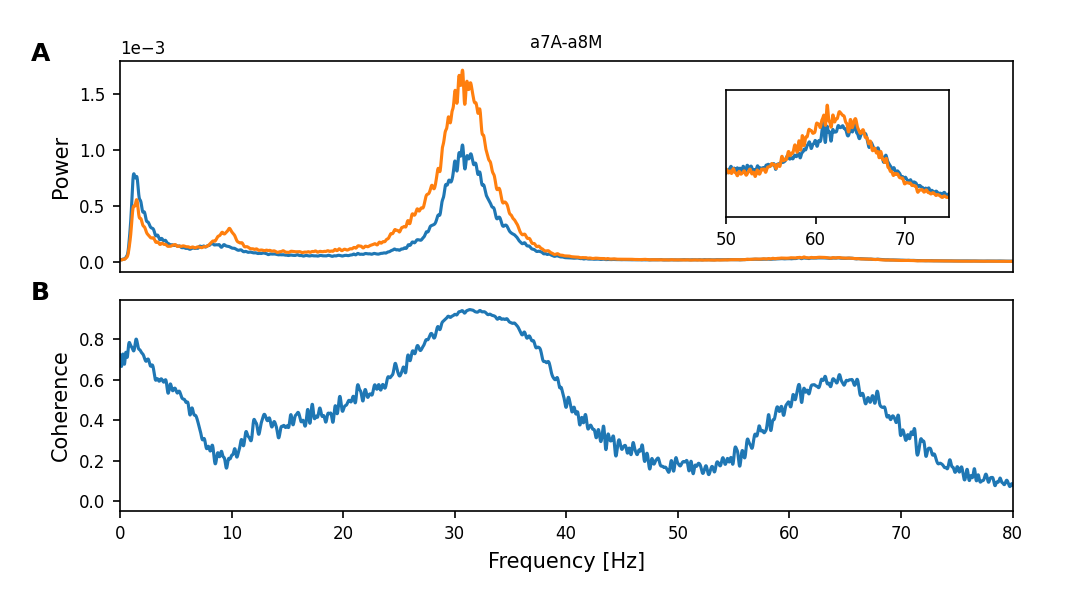

In [24]:
plot_power_spectra(f, px, py, pxy, title="a7A-a8M")

#### Time-resolved coherence

In [25]:
# Smoothing windows
sm_times = 0.3
sm_freqs = 1
sm_kernel = "square"
decim = 20

# Defining parameters
mode = "morlet"

n_freqs = 30
freqs = np.linspace(3, 75, n_freqs)
sigma_f = 4.0
n_cycles = freqs / sigma_f

In [26]:
kw = dict(
    freqs=freqs,
    times="time",
    roi="roi",
    foi=None,
    n_jobs=20,
    pairs=pairs,
    mode=mode,
    n_cycles=n_cycles,
    decim=decim,
    metric="coh",
    sm_kernel=sm_kernel,
    sm_times=sm_times,
    sm_freqs=sm_freqs,
    block_size=1,
    mt_bandwidth=None,
)

# compute the coherence
coh = conn_spec(data, **kw)

Computing pairwise Coherence (n_pairs=5, n_freqs=30, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    6.6s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    8.6s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    8.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

In [27]:
# compute the coherence for each surrogate
coh_surr = []
for i in range(n_surr):
    coh_surr += [conn_spec(data_surr[i], **kw)]

Computing pairwise Coherence (n_pairs=5, n_freqs=30, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    6.4s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    8.2s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    8.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

In [28]:
coh_surr = xr.concat(coh_surr, dim="seeds")

##### Estimating the bias

Following Lachaux et. al. (2002) the bias fo the wavelet coherence can be computed as:

$B = \left(1 + 2\frac{n_{cy}}{n_{co}}\right)^{-1}$

where, $n_{cy}$ is the number of cycles of the wavelet within the integration window $\delta$, and $n_{co}$ the number of cycles of the wavelet. The integration window is given by:

$\delta = n_{cy}/f$

Those function could be used to fit the bias of the wavelet coherence computed for white noise signals.

With our terminology, since we input $\delta$ (sm_times) to the function the bias can be written as:

$B = \left(1 + 2\frac{f\delta}{n_{co}}\right)^{-1}$

From this equation it is expected that the bias will be frequency dependent if $n_{co}$ is constant, and frequency independent if $n_{co}$ is proportional to frequency let's say $n_{co}=f/\sigma_f$, then:

$B = \left(1 + 2\delta\sigma_{t}\right)^{-1}$

By comparing the wavelet coherence measured for white noise we can validate the expression above.

In [29]:
def _bias_lachaux(sm_times, freqs, n_cycles):
    return (1 + 2 * sm_times * freqs / n_cycles) ** -1

In [30]:
n = 3650
sf = 1000

eta = xr.DataArray(
    np.random.normal(0, 1, size=(1, 30, n)),
    dims=("trials", "roi", "times"),
    coords={"times": np.arange(n) / sf},
)

In [31]:
delta = 1
# freqs    = np.linspace(10,100,30)
w_t = np.linspace(0.1, 1, 10)

n_cycles = freqs / sigma_f

kw = dict(
    freqs=freqs,
    times="times",
    roi="roi",
    foi=None,
    n_jobs=20,
    pairs=None,
    sfreq=1000,
    mode=mode,
    n_cycles=n_cycles,
    decim=delta,
    metric="coh",
    sm_kernel="square",
    sm_freqs=1,
    block_size=1,
)

coh_eta = []
for i in range(len(w_t)):
    kw["sm_times"] = w_t[i]
    coh_eta += [conn_spec(eta, **kw)]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=100, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=200, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=300, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=400, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.3s remaining:    0.8s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=500, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=600, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=700, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=800, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=900, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=1000, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

In [32]:
B = []
B_t = []

for i in range(len(w_t)):
    B += [coh_eta[i].isel(times=slice(20, -20)).squeeze().mean(dim=("roi", "times"))]
    B_t += [_bias_lachaux(w_t[i], freqs, n_cycles)]

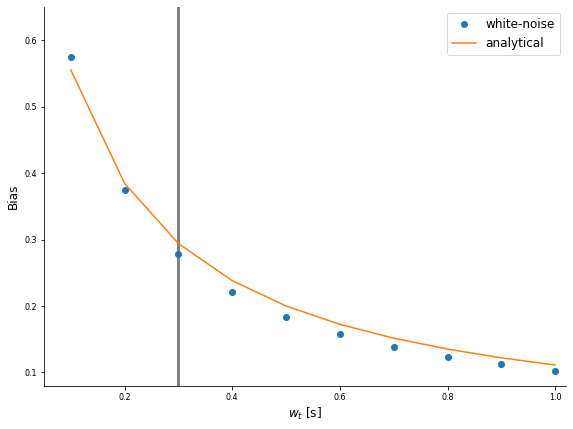

In [33]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
B_total = np.mean(B, -1)
B_t_total = np.mean(B_t, -1)
plt.plot(w_t, B_total, "o", label="white-noise")
plt.plot(w_t, B_t_total, "-", label="analytical")
plt.legend(fontsize=BIGGER_SIZE)
plt.vlines(0.3, 0, 0.7, "gray", lw=3)
plt.ylim(0.08, 0.65)
plt.xlim(0.05, 1.02)
plt.ylabel("Bias", fontsize=BIGGER_SIZE)
plt.xlabel(r"$w_t$ [s]", fontsize=BIGGER_SIZE)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.tight_layout()

##### Single-trials of time-resolved coherence
Here, we correct the coherence values using the $95\%$ percentile of the surrogate coherence taken across the trials dimension. We also consider that correcting the coherence values by removing non-siginificant values we also correct for the bias, since it is also prenset in the surrogate coherences.

In [34]:
thr = coh_surr.isel(seeds=0).quantile(0.95, dim="trials")

In [35]:
# Eliminating non-siginificant values
coh_sig = coh * (coh >= thr)

In [36]:
def plot_single_trial_coh(roi, trial):

    fig = plt.figure(figsize=(7.0, 3.8), dpi=150)

    ch1, ch2 = pairs[roi, 0], pairs[roi, 1]

    gs1 = fig.add_gridspec(
        nrows=1, ncols=1, left=0.05, right=0.90, bottom=0.55, top=0.92
    )
    gs2 = fig.add_gridspec(
        nrows=1, ncols=1, left=0.087, right=0.865, bottom=0.1, top=0.50
    )
    gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.90, right=0.92, bottom=0.1, top=0.5)

    ax1 = plt.subplot(gs1[0])

    plt.sca(ax1)
    plt.plot(
        data.time, data.isel(roi=ch1, trials=trial), lw=0.6, label=data.roi.values[ch1]
    )
    plt.plot(
        data.time,
        data.isel(roi=ch2, trials=trial) + 4e-4,
        lw=0.6,
        label=data.roi.values[ch2],
    )
    plt.axis("off")
    plt.title(
        f"{data.roi.values[ch1]}-{data.roi.values[ch2]}, trial {data.trials.values[trial]}"
    )

    ax2 = plt.subplot(gs2[0])

    plt.sca(ax2)
    extent = [coh_sig.times[0], coh_sig.times[-1], coh_sig.freqs[0], coh_sig.freqs[-1]]
    plt.imshow(
        coh_sig.isel(roi=roi, trials=trial),
        aspect="auto",
        cmap="turbo",
        vmin=0,
        vmax=1,
        origin="lower",
        extent=extent,
    )

    ax3 = plt.subplot(gs3[0])
    # COLORBAR
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    cbar = plt.colorbar(
        mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.turbo, norm=norm),
        cax=ax3,
        extend=None,
        shrink=0.1,
    )
    cbar.ax.set_ylabel("coherence", rotation="vertical")

    bg = plot.Background(visible=False)

    plot.add_panel_letters(
        fig, axes=[ax1, ax2], fontsize=12, xpos=[0, -0.05], ypos=[0.9, 1.1]
    )

##### a8B-a8M

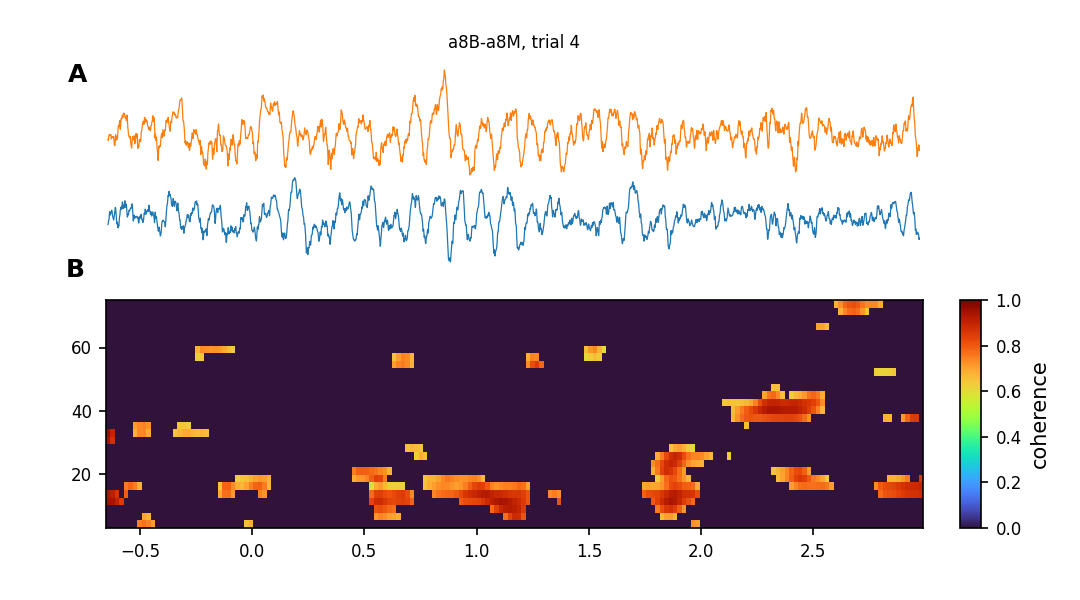

In [37]:
plot_single_trial_coh(0, 1)

##### a8B-a8M

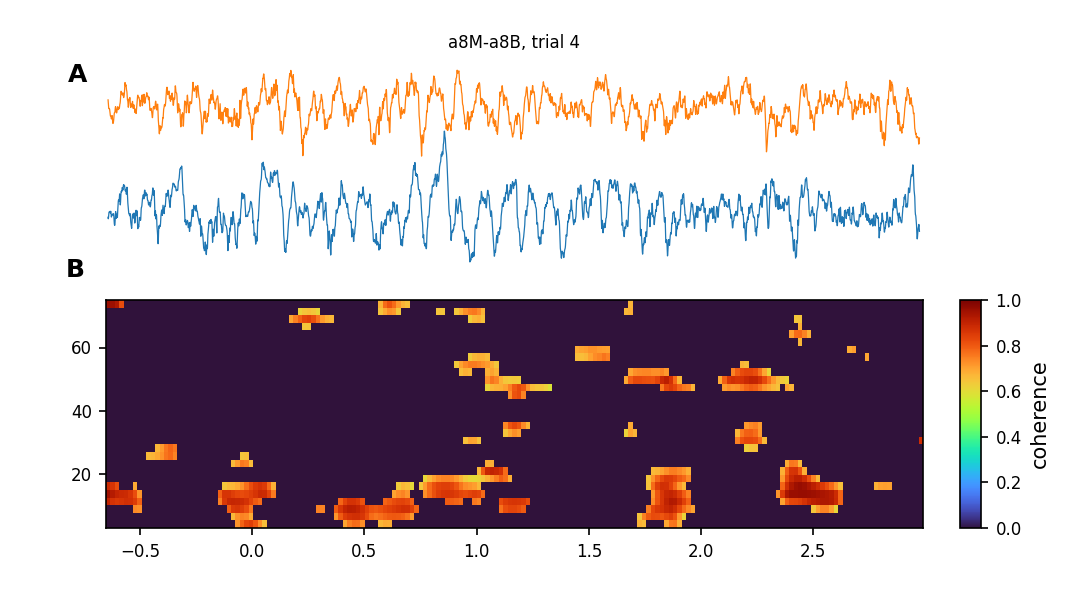

In [38]:
plot_single_trial_coh(1, 1)

##### a7A-a8M

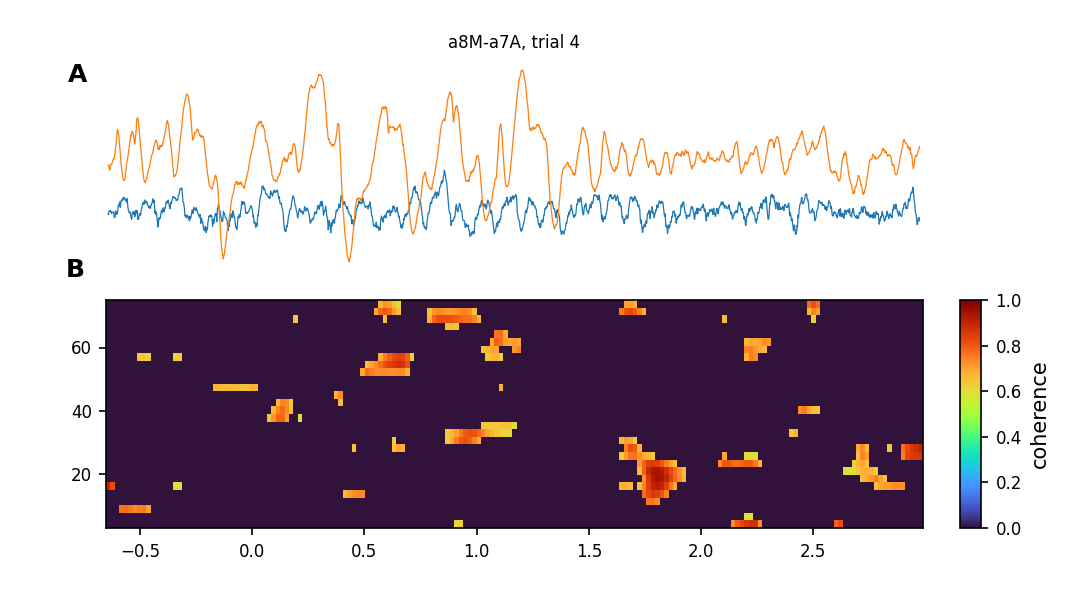

In [39]:
plot_single_trial_coh(2, 1)

##### F1-F1

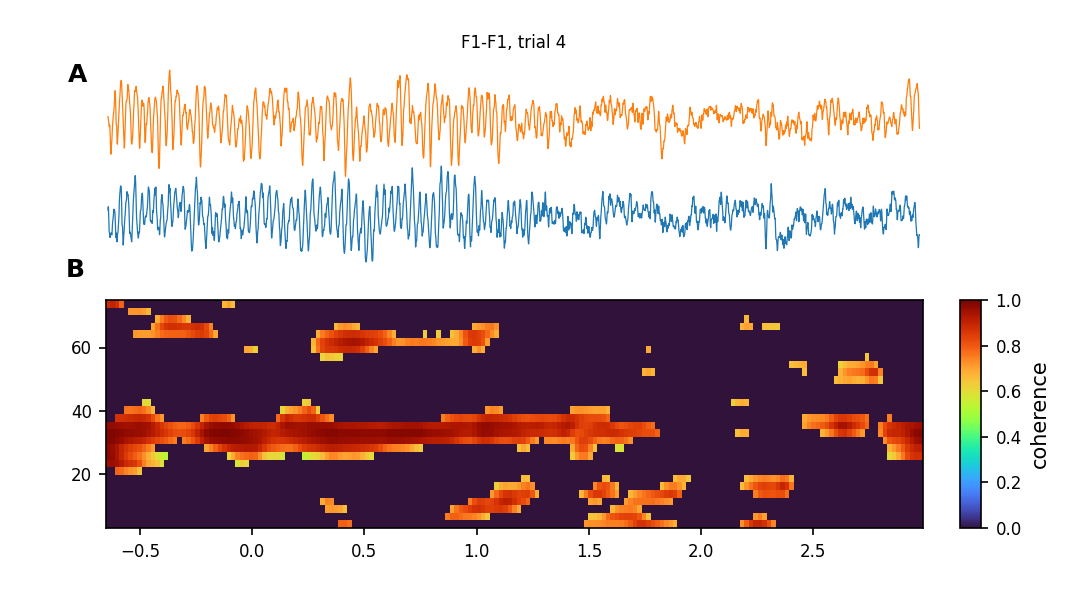

In [40]:
plot_single_trial_coh(3, 1)

##### a3-F1

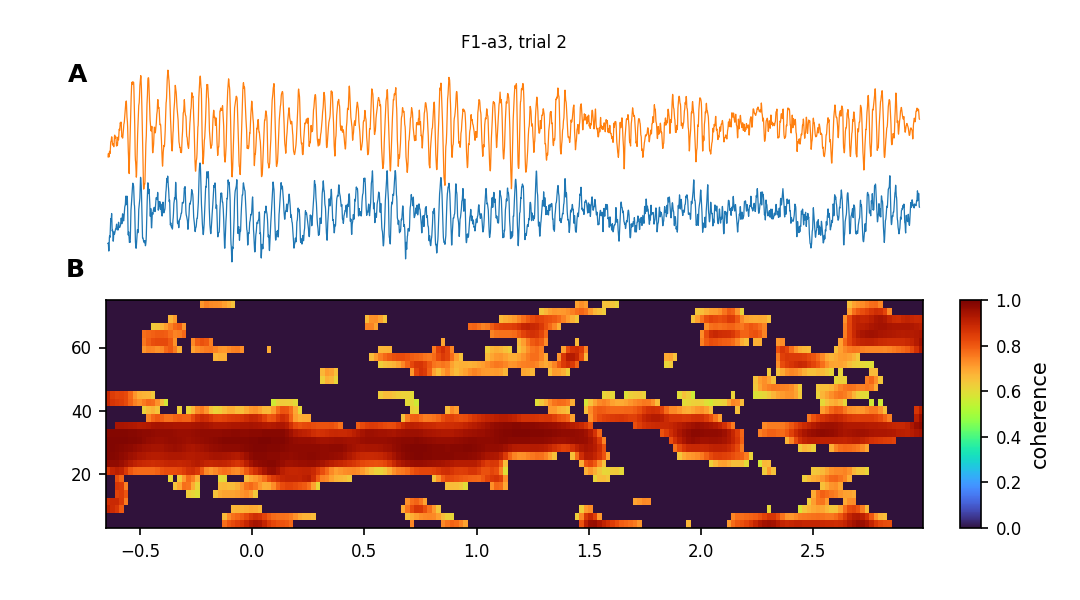

In [41]:
plot_single_trial_coh(4, 0)

### Comparing wavelet and Hilbert based coherence 

In [44]:
from xfrites.conn.conn_coh import conn_coherence_hilbert

In [45]:
kw = dict(
    times="time",
    roi="roi",
    freqs=freqs,
    f_bw=np.array([sigma_f] * len(freqs)),
    n_jobs=20,
    decim=decim,
    block_size=1,
    kw_filter=dict(method="iir"),
    pairs=pairs,
    sm_kernel=sm_kernel,
    sm_times=sm_times,
)

In [46]:
coh_hil = conn_coherence_hilbert(data, **kw)
coh_hil_surr = conn_coherence_hilbert(data_surr, **kw)

Setting up low-pass filter at 7 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 7.00 Hz: -6.02 dB



[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  70 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 1470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 25416 tasks      | elapsed:    5.1s
[Parallel(n_jobs=20)]: Done 26960 tasks      | elapsed:    5.7s
[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.7s finished


Setting up band-pass filter from 1.5 - 9.5 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.48, 9.48 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.7s


Setting up band-pass filter from 4 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 3.97, 11.97 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.6s


Setting up band-pass filter from 6.4 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.45, 14.45 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.8s


Setting up band-pass filter from 8.9 - 17 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.93, 16.93 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.4s


Setting up band-pass filter from 11 - 19 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 11.41, 19.41 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.6s


Setting up band-pass filter from 14 - 22 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 13.90, 21.90 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.6s


Setting up band-pass filter from 16 - 24 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 16.38, 24.38 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.6s


Setting up band-pass filter from 19 - 27 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 18.86, 26.86 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.5s


Setting up band-pass filter from 21 - 29 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 21.34, 29.34 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.7s


Setting up band-pass filter from 24 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 23.83, 31.83 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 25804 tasks      | elapsed:    3.8s


Setting up band-pass filter from 26 - 34 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 26.31, 34.31 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.2s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.4s


Setting up band-pass filter from 29 - 37 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 28.79, 36.79 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.7s


Setting up band-pass filter from 31 - 39 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 31.28, 39.28 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.9s


Setting up band-pass filter from 34 - 42 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 33.76, 41.76 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.7s


Setting up band-pass filter from 36 - 44 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 36.24, 44.24 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 25804 tasks      | elapsed:    4.0s


Setting up band-pass filter from 39 - 47 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 38.72, 46.72 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.7s


Setting up band-pass filter from 41 - 49 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 41.21, 49.21 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.5s


Setting up band-pass filter from 44 - 52 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 43.69, 51.69 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.7s


Setting up band-pass filter from 46 - 54 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 46.17, 54.17 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.7s


Setting up band-pass filter from 49 - 57 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 48.66, 56.66 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 110 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.3s


Setting up band-pass filter from 51 - 59 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 51.14, 59.14 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.7s


Setting up band-pass filter from 54 - 62 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 53.62, 61.62 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.8s


Setting up band-pass filter from 56 - 64 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 56.10, 64.10 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.6s


Setting up band-pass filter from 59 - 67 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 58.59, 66.59 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.6s


Setting up band-pass filter from 61 - 69 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 61.07, 69.07 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.4s


Setting up band-pass filter from 64 - 72 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 63.55, 71.55 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.6s


Setting up band-pass filter from 66 - 74 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 66.03, 74.03 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.5s finished


Setting up band-pass filter from 69 - 77 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 68.52, 76.52 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.6s


Setting up band-pass filter from 71 - 79 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 71.00, 79.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.6s
[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    4.8s finished
Compute pairwise coherence (n_pairs=5, n_freqs=30, decim=20


  0%|          | Estimating pairwise coherence : 0/5 [00:00<?,       ?it/s]

PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
aux1 = coh * (coh >= coh_sig)
aux2 = coh_hil * (coh_hil >= coh_hil_surr)

In [ ]:
plt.figure(figsize=(15, 12))
count = 1
for roi in range(4):
    plt.subplot(4, 2, count)
    aux1.isel(roi=roi).sel(times=slice(-0.5, 2.5)).mean("trials").plot.imshow(
        x="times", y="freqs", cmap="turbo"
    )
    count += 1
    plt.subplot(4, 2, count)
    aux2.isel(roi=roi).sel(times=slice(-0.5, 2.5)).mean("trials").plot.imshow(
        x="times", y="freqs", cmap="turbo"
    )
    count += 1
plt.tight_layout()